In [ ]:
DATA = 'D:\\Research\\'

**Opening file with training tweets**

In [1]:
#seach for organic tweets and save them in one list
from collections import Counter
import csv
tweets=[]
positive_tweets = 0
negative_tweets = 0
other_tweets = 0


with open( DATA+'2000_PositiveandNeutral.csv', "rb") as theFile:
    reader = csv.DictReader( theFile )
    for row in reader:
        if row['sent']== '1':
            positive_tweets += 1
        elif row['sent']== '-1':
            negative_tweets += 1
        else:
            other_tweets += 1
            
        tweets.append(row)
        
print 'We have', len(tweets), 'sampled tweets'
print positive_tweets, 'are positive'
print negative_tweets, 'are negative'
print other_tweets, 'are nothing'

We have 2000 sampled tweets
676 are positive
0 are negative
1324 are nothing


In [2]:
# Create label vector (y) that show the class labels of each tweet
#print the count of each class label
from collections import Counter
import numpy as np

y = np.array([int(t['sent']) for t in tweets])#savind labels of the class in y
print 'label counts=', Counter(y)


label counts= Counter({0: 1324, 1: 676})


Populating the interactive namespace from numpy and matplotlib


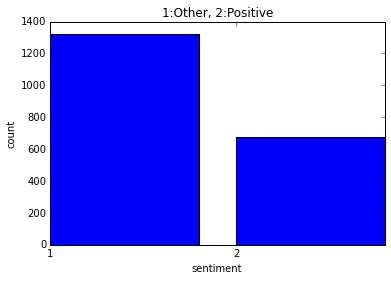

In [3]:
%pylab inline
# What is the distribution of scores?
from collections import Counter
import matplotlib.pyplot as plt

counts = Counter(y).values()
vals = [1,2]

plt.bar(vals, counts)
plt.xticks(vals)
plt.xlabel('sentiment')
plt.ylabel('count')
plt.title('1:Other, 2:Positive')
plt.show()

In [6]:
#########################
####Tokenizing method####
#########################


def tokenize1(string, lowercase=True, keep_punctuation=False,collapse_urls=True, collapse_mentions=True):
    if not string:
        return []
    if lowercase:
        string = string.lower()
    tokens = []
    if collapse_urls:
        string = re.sub('http\S+', 'THIS_IS_A_URL', string)
    if collapse_mentions:
        string = re.sub('@\S+', 'THIS_IS_A_MENTION', string)
    if keep_punctuation:
        tokens = string.split()
    else:
        tokens = re.sub('\W+', ' ', string).split()
    return tokens

def tweet2tokens(tweet, lowercase=True,keep_punctuation=True,collapse_urls=True, collapse_mentions=True):
    tokens = tokenize(tweet['text'], lowercase, keep_punctuation, collapse_urls, collapse_mentions)
    return tokens


In [7]:
####################
###Feature vector###
####################

import re
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=2, tokenizer=tokenize1,binary=False)#lowercase, url's, mentions
X = vectorizer.fit_transform(t['text'] for t in tweets)
print 'vectorized %d tweet. found %d terms.' % (X.shape[0], X.shape[1])

vectorized 2000 tweet. found 1996 terms.


** Fitting LG model - default parameters**

In [8]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

def do_cv(X, y, nfolds=10):
    cv = KFold(len(y), nfolds)
    return np.mean(cross_val_score(LogisticRegression(), X, y, cv=cv))
  
print do_cv(X, y)

0.8105


In [9]:
# Fit a LogisticRegression model
model = LogisticRegression()
model.fit(X, y)

# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = model.predict(X)
print 'accuracy on training data=%.3f' % accuracy(y, predicted)


# 5 Cross-validation accuracy
from sklearn.cross_validation import KFold

cv = KFold(len(y), 10)
accuracies = []
print 'Fitting in the labeled data:'
#print 'Train set:',X[train_ind].shape[0], '\f Test set:', X[test_ind].shape[0]
for train_ind, test_ind in cv:
    model.fit(X[train_ind], y[train_ind])
    
    predictions = model.predict(X[test_ind])
    accuracies.append(accuracy(y[test_ind], predictions))
    
print 'Average 5-fold cross validation accuracy=%.4f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies))

accuracy on training data=0.864
Fitting in the labeled data:
Average 5-fold cross validation accuracy=0.8105 (std=0.03)


In [10]:
#confusion matrix for model_mod (best parameters - actually same default)
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd


y_pred = model.predict(X)

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0,1], index=[0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm
    
confusion_matrix(y, y_pred)

error rate: 0.14


Predicted,0,1
Expected,,
0,1267,57
1,228,448


In [11]:
#precision, recall and F1 measures for both classes
from sklearn.metrics import precision_recall_fscore_support
y_true = y
y_pred = model.predict(X)
print precision_recall_fscore_support(y_true, y_pred)

(array([ 0.84749164,  0.88712871]), array([ 0.95694864,  0.66272189]), array([ 0.89890032,  0.75867909]), array([1324,  676], dtype=int64))


**Changing parameters of LG classifier **

Parameter: l1 Accuracy: 0.797
Parameter: l2 Accuracy: 0.8105


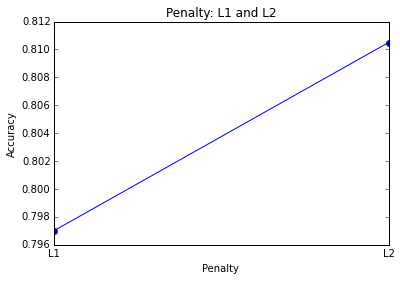

In [12]:
# changing parameters of classifier 
#penalty=l1 and l2
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

def do_cv_penalty(X, y, penalty, nfolds=10):
    cv = KFold(len(y), nfolds)
    return np.mean(cross_val_score(LogisticRegression(penalty=penalty), X, y, cv=cv))
  

import matplotlib.pyplot as plt

def compare_ngrams(tweets, y):
    accuracies = []
    clf_param = ['l1','l2']
    i=0
    for pr in clf_param:
        accuracies.append(do_cv_penalty(X,y,penalty=pr))
        print 'Parameter:', pr, 'Accuracy:', accuracies[i]
        i+=1
    plt.figure()
    plt.plot(accuracies, 'bo-')
    #plt.xticks(range(len(pr)), pr)
    plt.xticks(range(2), ['L1','L2'] )
    plt.title('Penalty: L1 and L2')
               
    plt.xlabel('Penalty')
    plt.ylabel('Accuracy')
    plt.show()
        
compare_ngrams(tweets, y)



C parameter: 0.01 Accuracy: 0.662
C parameter: 0.5 Accuracy: 0.7955
C parameter: 0.6 Accuracy: 0.8035
C parameter: 0.7 Accuracy: 0.8045
C parameter: 0.8 Accuracy: 0.8055
C parameter: 0.9 Accuracy: 0.808
C parameter: 1 Accuracy: 0.8105
C parameter: 2.6 Accuracy: 0.818
C parameter: 5 Accuracy: 0.8125
C parameter: 10 Accuracy: 0.8035
C parameter: 30 Accuracy: 0.8015
C parameter: 50 Accuracy: 0.7965
C parameter: 70 Accuracy: 0.7945
C parameter: 100 Accuracy: 0.7905


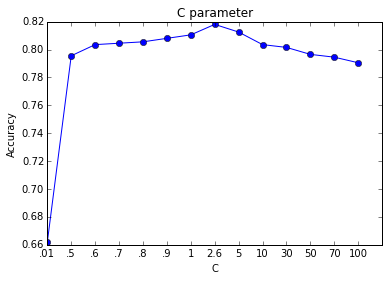

In [13]:
# changing parameters of classifier 
#C
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

def do_cv_C(X, y, c, nfolds=10):
    cv = KFold(len(y), nfolds)
    return np.mean(cross_val_score(LogisticRegression(C=c), X, y, cv=cv))
  

import matplotlib.pyplot as plt

def compare_c(tweets, y):
    accuracies = []
    c_param = [.01, .5,.6,.7,.8,.9,1,2.6, 5, 10, 30,50,70,100]
    i=0
    for c in c_param:
        accuracies.append(do_cv_C(X,y,c))
        print 'C parameter:',c,'Accuracy:',accuracies[i]
        i+=1
    plt.figure()
    plt.plot(accuracies, 'bo-')
    #plt.xticks(range(len(c)), c)
    #plt.xticks(c_param)
    plt.xticks(range(14), ['.01', '.5','.6','.7','.8','.9','1','2.6' ,'5', '10', '30','50','70','100'])
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title('C parameter')
    plt.show()   
compare_c(tweets, y)
 

In [14]:
# Fit a LogisticRegression model modified parameters 

from sklearn.linear_model import LogisticRegression
model_mod = LogisticRegression(penalty='l2', C=2.6)
model_mod.fit(X, y)

# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = model_mod.predict(X)
print 'accuracy on training data=%.4f' % accuracy(y, predicted)


# 5 Cross-validation accuracy
from sklearn.cross_validation import KFold

cv = KFold(len(y), 10)
accuracies = []
for train_ind, test_ind in cv:
    model_mod.fit(X[train_ind], y[train_ind])
    
    predictions = model_mod.predict(X[test_ind])
    accuracies.append(accuracy(y[test_ind], predictions))
    
print 'Average 5-fold cross validation accuracy=%.4f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies))

accuracy on training data=0.9055
Average 5-fold cross validation accuracy=0.8180 (std=0.03)


In [69]:
# Do GridSearch on all parameters.
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint

pipeline = Pipeline([
    ('vect', TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=2, tokenizer=tokenize1,binary=False)),
    ('clf', LogisticRegression()),
])

parameters = {
    'clf__penalty': ('l1','l2'),
    'clf__C': (.01, .5,.6,.7,.8,.9,1,1.5,2,2.5,2.6,3, 5, 10, 30,50,70, 100),  
}

data = [t['text'] for t in tweets]
grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=KFold(len(y), 10))

print "Performing grid search..."
print "pipeline:", [name for name, _ in pipeline.steps]
print "parameters:"
pprint(parameters)
grid_search.fit(data, y)
print "done."

print("Best score: %0.4f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:   17.2s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   44.9s finished


Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__C': (0.01,
            0.5,
            0.6,
            0.7,
            0.8,
            0.9,
            1,
            1.5,
            2,
            2.5,
            2.6,
            3,
            5,
            10,
            30,
            50,
            70,
            100),
 'clf__penalty': ('l1', 'l2')}
Fitting 10 folds for each of 36 candidates, totalling 360 fits
done.
Best score: 0.8175
Best parameters set:
	clf__C: 2.6
	clf__penalty: 'l2'


In [15]:
#confusion matrix for model_mod (best parameters)

from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd


y_pred = model_mod.predict(X)

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0,1], index=[0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm
    
confusion_matrix(y, y_pred)

error rate: 0.10


Predicted,0,1
Expected,,
0,1269,55
1,145,531


In [16]:
#precision, recall and F1 measures for both classes
from sklearn.metrics import precision_recall_fscore_support
y_true = y
y_pred = model_mod.predict(X)
print precision_recall_fscore_support(y_true, y_pred)

(array([ 0.89745403,  0.90614334]), array([ 0.95845921,  0.78550296]), array([ 0.92695398,  0.84152139]), array([1324,  676], dtype=int64))


# SGD Classifier

In [18]:
# Do GridSearch on all parameters for SGD classifier
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from sklearn.linear_model import SGDClassifier

pipeline = Pipeline([
    ('vect', TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=2, tokenizer=tokenize1,binary=False)),
    ('clf', SGDClassifier()),
])

parameters = {
    'clf__penalty': ('none', 'l2', 'l1', 'elasticnet'),
    'clf__alpha': (.0001, .0005,.0006,.0007,.0008,.0009,.001, 5, 10, 100),  
}

data = [t['text'] for t in tweets]
grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=KFold(len(y), 10))

print "Performing grid search..."
print "pipeline:", [name for name, _ in pipeline.steps]
print "parameters:"
pprint(parameters)
grid_search.fit(data, y)
print "done."

print("Best score: %0.4f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:   12.4s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   24.9s finished


Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (0.0001,
                0.0005,
                0.0006,
                0.0007,
                0.0008,
                0.0009,
                0.001,
                5,
                10,
                100),
 'clf__penalty': ('none', 'l2', 'l1', 'elasticnet')}
Fitting 10 folds for each of 40 candidates, totalling 400 fits
done.
Best score: 0.8140
Best parameters set:
	clf__alpha: 0.0005
	clf__penalty: 'l2'


**SGD model**

In [17]:
# Fit a SGD model
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(penalty='l2', alpha=0.0005)
clf.fit(X, y)

# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = clf.predict(X)
print 'accuracy on training data=%.3f' % accuracy(y, predicted)


# 5 Cross-validation accuracy
from sklearn.cross_validation import KFold

cv = KFold(len(y), 10)
accuracies = []

for train_ind, test_ind in cv:
    clf.fit(X[train_ind], y[train_ind])
    
    predictions = clf.predict(X[test_ind])
    accuracies.append(accuracy(y[test_ind], predictions))
    
print 'Average 5-fold cross validation accuracy=%.4f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies))

accuracy on training data=0.907
Average 5-fold cross validation accuracy=0.8130 (std=0.03)


In [18]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd


y_pred = clf.predict(X)

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0,1], index=[0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm
    
confusion_matrix(y, y_pred)

error rate: 0.10


Predicted,0,1
Expected,,
0,1292,32
1,161,515


In [19]:
#precision, recall and F1 measures for classes from SGD classifier
from sklearn.metrics import precision_recall_fscore_support
y_true = y
y_pred = clf.predict(X)
print '1',precision_recall_fscore_support(y_true, y_pred)

1 (array([ 0.88919477,  0.94149909]), array([ 0.97583082,  0.76183432]), array([ 0.93050054,  0.84219133]), array([1324,  676], dtype=int64))


In [20]:
# How does tokenization affect accuracy?
# Collapse urls and mentions; ignore description prefix.
from itertools import product
def run_all(tweets, lowercase=True,
            keep_punctuation=True, descr_prefix=None,
            collapse_urls=True, collapse_mentions=True):
    
    #vectorizer = TfidfVectorizer(decode_error='ignore', stop_words='english', tokenizer=tokenize1)#lowercase, url's, mentions
    #A = vectorizer.fit_transform(t['text'] for t in tweets)
    
    tokens_list = [tweet2tokens(t, lowercase, keep_punctuation,collapse_urls, collapse_mentions) for t in tweets]
    vocabulary = make_vocabulary(tokens_list)
    A = make_feature_matrix(tokens_list, vocabulary)
    print 'acc=', do_cross_val(A, y, 5)

In [22]:
# Store these in a sparse matrix.

#1) Create a vocabulary (dict from term->index)

# https://docs.python.org/2/library/collections.html#collections.defaultdict
from collections import defaultdict

def make_vocabulary(tokens_list):
    vocabulary = defaultdict(lambda: len(vocabulary))
    for tokens in tokens_list:
        for token in tokens:
            vocabulary[token]
    print '%d unique terms in vocabulary' % len(vocabulary)
    return vocabulary

# Convert features to a sparse matrix X.
# X[i,j] is the frequency of term j in tweet i
# 
from scipy.sparse import lil_matrix #list of list (LIL)

def make_feature_matrix(tokens_list, vocabulary):
    X = lil_matrix((len(tweets), len(vocabulary)))
    for i, tokens in enumerate(tokens_list):
        for token in tokens:
            j = vocabulary[token]
            X[i,j] += 1
    return X.tocsr()


# Do 5-fold cross-validation
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

def do_cross_val(X, y, nfolds):
    """ Compute average cross-validation acccuracy."""
    cv = KFold(len(y), nfolds)
    accuracies = []
    for train_idx, test_idx in cv:
        clf = LogisticRegression()
        clf.fit(X[train_idx], y[train_idx])
        predicted = clf.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], predicted)
        accuracies.append(acc)
    avg = np.mean(accuracies)
    return avg


argnames = ['lower', 'punct', 'url', 'mention']
lowercase_opts = [True, False]
keep_punctuation_opts = [True, False]
url_opts = [True, False]
mention_opts = [True, False]

option_iter = product(lowercase_opts, keep_punctuation_opts,url_opts, mention_opts)

for options in option_iter:
    print '\t'.join('%s=%s' % (name, opt) for name, opt in zip(argnames, options))
    run_all(tweets, *options)
    print

lower=True	punct=True	url=True	mention=True
7653 unique terms in vocabulary
acc= 0.801

lower=True	punct=True	url=True	mention=False
8312 unique terms in vocabulary
acc= 0.8045

lower=True	punct=True	url=False	mention=True
7653 unique terms in vocabulary
acc= 0.801

lower=True	punct=True	url=False	mention=False
8312 unique terms in vocabulary
acc= 0.8045

lower=True	punct=False	url=True	mention=True
5761 unique terms in vocabulary
acc= 0.8025

lower=True	punct=False	url=True	mention=False
6401 unique terms in vocabulary
acc= 0.805

lower=True	punct=False	url=False	mention=True
5761 unique terms in vocabulary
acc= 0.8025

lower=True	punct=False	url=False	mention=False
6401 unique terms in vocabulary
acc= 0.805

lower=False	punct=True	url=True	mention=True
8638 unique terms in vocabulary
acc= 0.7985

lower=False	punct=True	url=True	mention=False
9297 unique terms in vocabulary
acc= 0.795

lower=False	punct=True	url=False	mention=True
8638 unique terms in vocabulary
acc= 0.7985

lower=Fal

# Testing not labeled tweets

In [21]:
import gzip
DATA='D:\\Research\\'

In [22]:
#open organic tweets - set of more than 900k

from collections import Counter
import csv
test_tweets=[]
i=1

with open( DATA + 'organicDef.csv', "rb" ) as theFile:
    reader = csv.DictReader( theFile )
    for row in reader:
        test_tweets.append(row) 
        i+=1
        
print 'We have', len(test_tweets), ' tweets'

We have 992633  tweets


In [23]:
# Create feature vector for testing tweets (XX)
from sklearn.feature_extraction.text import TfidfVectorizer
XX = vectorizer.transform(t['text'] for t in test_tweets)

In [24]:
print test_tweets[1]['text'], test_tweets[1]['posted_time']

nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/AVCtEml4 10/1/2012 00:01:19


**Predicting classes**

In [25]:
prediction = model_mod.predict(XX)

In [26]:
i=0
for doc, classe in zip(test_tweets, prediction):
    print('%r => %s' % (doc['text'], classe))
    if i==100:
        break
    i+=1

'Getting an e cig tomorrow :)' => 1
'nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/AVCtEml4' => 0
'Really \xe3?? nice!: USB Rechargeable Electronic Cigarette Lighter - Green http://t.co/JS65DjB3' => 0
'Smoking an e-cig is the equivalent to smoking smarties. You look like a faggot' => 0
'Advertise Ecigs HQ on Social Media Sites http://t.co/KmE6lHcq' => 0
'Photo: pizzzatime: nickdrake:\xc2\xa0C3P0 Enjoys a cigarette break during filming. http://t.co/neyow8Go' => 0
"RT @VapeLink: Tomorrow on Vapelink 9:30 EST: Mr. Ecig from Nu-vapor Forum! We'll also talk hardware.news.... and the usual banter!! http ..." => 0
'#starwars RT @pizzzatimes nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/NcAlTYRA' => 0
'Ecig finally died #rip' => 1
"I'm defo buying an E-Cig tomorrow!" => 1
'pizzzatime: nickdrake: C3P0 Enjoys a cigarette break during filming.  C3P0 I AM EXTREMELY DISAPPOINTED IN YOU. http://t.co/N3psXH9o' => 0
'lol at the random kid who asked me for 

In [27]:
#percentage of positives and negatives tweets from the test set
aaa= list(prediction)
print aaa.count(1)/float(992633) * 100
print aaa.count(0)/float(992633) *100


26.7803911415
73.2196088585


# New model built with testing tweets

In [28]:
#fitting a new model with the testing tweets

# Create feature vectors (X)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_ = TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=2, tokenizer=tokenize1,binary=False)#lowercase, url's, mentions
X_testing_set = vectorizer_.fit_transform(t['text'] for t in test_tweets)
print 'vectorized %d tweet. found %d terms.' % (X_testing_set.shape[0], X_testing_set.shape[1])

a1 = [line.rstrip('\n') for line in open('D:\Research\probs.txt')]
y_testing_set = [int(numeric_string) for numeric_string in a1]
 

from sklearn.linear_model import LogisticRegression
model_testing_set = LogisticRegression(penalty='l2', C=2.6)
model_testing_set.fit(X_testing_set, y_testing_set)

model_testing_set.coef_[0]

# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = model_testing_set.predict(X_testing_set)
print 'accuracy on training data=%.4f' % accuracy(y_testing_set, predicted)


vectorized 992633 tweet. found 102035 terms.
accuracy on training data=0.9905


**accuracy of the new model in the same set**

In [29]:
#accuracy of model built from testing tweets
print 'Accuracy = ',do_cv(X_testing_set, y_testing_set)

Accuracy =  0.979106071964


In [30]:
#top coeficients for the definitive LG model --> model_mod

coefs = sorted(zip(vectorizer.get_feature_names(),model_mod.coef_[0]),key=lambda x:x[1])
print coefs[0:30], '\n'
print coefs[-30:]


[(u'THIS_IS_A_URL', -5.1483060621136154), (u'retail', -2.0692641392328475), (u'cigarettes', -1.8429090464247777), (u'he', -1.8366358151013316), (u'smokes', -1.8035637383030247), (u'stores', -1.799054298483679), (u'everyone', -1.7466173782898911), (u'de', -1.6323575803621808), (u'kid', -1.6103108586596862), (u'you', -1.5830112744577913), (u'as', -1.5805783068715218), (u'if', -1.5784604509469744), (u'dallas', -1.5340571659247813), (u'ego', -1.5292046613384573), (u'ni', -1.5227773089872854), (u'being', -1.4773547971230481), (u'many', -1.4678124332030851), (u'is', -1.4602921561614177), (u'go', -1.4015816771382479), (u'via', -1.3856679194184656), (u'people', -1.3676682640620654), (u'even', -1.3558702118759669), (u'any', -1.3411384745928754), (u'one', -1.3172699123890079), (u'by', -1.3106653616254409), (u'bro', -1.3097402338874682), (u'10', -1.2790340347140234), (u'why', -1.2690714243156891), (u'she', -1.2666827451062164), (u'sorry', -1.258776429129741)] 

[(u're', 1.3749668500153962), (u'wi

** Confusion matrix, precision, recall and r-score from the model built from testing tweets**

In [31]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd


y_pred1 = model_testing_set.predict(X_testing_set)

def confusion_matrix(y_testing_set, y_pred1):
    cm = sk_confusion_matrix(y_testing_set, y_pred1)
    cm = pd.DataFrame(data=cm, columns=[0,1], index=[0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred1 != y_testing_set).mean()
    print('error rate: %.2f' % error_rate)
    return cm
    

#precision, recall and F1 measures for classes from SGD classifier
from sklearn.metrics import precision_recall_fscore_support
y_true = y_testing_set
y_pred1 = model_testing_set.predict(X_testing_set)

print 'Precision, recall, fscore:',precision_recall_fscore_support(y_true, y_pred1), '\n'

confusion_matrix(y_testing_set, y_pred1)

Precision, recall, fscore: (array([ 0.99303084,  0.98347678]), array([ 0.99397222,  0.98092773]), array([ 0.99350131,  0.9822006 ]), array([726802, 265831], dtype=int64)) 

error rate: 0.01


Predicted,0,1
Expected,,
0,722421,4381
1,5070,260761


In [35]:
#saving the labels in one file
numpy.savetxt(DATA+'probsDef.txt', prediction, delimiter=",")

**Merging files with predicted labels and tweets**

In [36]:
import csv
all1 = []
i=-1
# generates testingTweets_Classified csv

with open(DATA+'test.csv','rb') as csvinput: #test.csv is the file probsDef, but formated into 1's and 0's
    with open(DATA+'output1.csv', 'wb') as csvoutput:
        with open(DATA+'organicDef.csv') as file1:
            writer = csv.writer(csvoutput, lineterminator='\n')
            reader = csv.reader(csvinput)
            reader1 = csv.reader(file1)

            for row in reader1:
                if i==-1:
                    row[38] = 'class'
                elif i >= 0:
                    row[38]=prediction[i]     
                writer.writerow(row) 
                i+=1
                if i > 992632:
                    break
     

**Reading file with all testing tweets, which were classified**

In [1]:
from collections import Counter
import csv
labeled_tweets=[]
pos = 0
neg = 0

with open( DATA+'testingTweets_Classified.csv', "rb" ) as theFile:
    reader = csv.DictReader( theFile )
    for row in reader:
        labeled_tweets.append(row)
        if row['class'] == '1':
            pos+=1
        else:
            neg+=1
print pos, ' tweets are positive and', neg, 'are negative'

265831  tweets are positive and 726802 are negative


In [37]:
print labeled_tweets[1]['posted_time'],labeled_tweets[1]['text'],labeled_tweets[1]['class']

10/1/2012 00:01:19 nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/AVCtEml4 0


#Parse posted time (date), generate graph with tweets by month

In [38]:
# Tweets by month.
import matplotlib.pyplot as plt
import datetime
%pylab inline
def parse_date(datestring):
    """ Input, e.g., 10/1/2012
    Output, e.g., 2012-10"""
    parts = datestring.split()
    if len(parts) > 1:
        datestring = parts[0]
        parts = datestring.split('/')
        if len(parts) == 3:
            s = (parts[2] if len(parts[2]) == 4 else '20' + parts[2]) + \
            '-' + (parts[0] if len(parts[0]) == 2 else '0'+parts[0])
            return datetime.datetime.strptime(s, "%Y-%m").date()
    return None

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


All tweets [30026, 36995, 46271, 62883, 65971, 90870, 110735, 84692, 96447, 94180, 114894, 158669] .Total:  992633
Positive tweets [8493, 10135, 13116, 17242, 18652, 22375, 28034, 24310, 23276, 26574, 31461, 42163] .Total:  265831
Negative tweets [21533, 26860, 33155, 45641, 47319, 68495, 82701, 60382, 73171, 67606, 83433, 116506] .Total:  726802


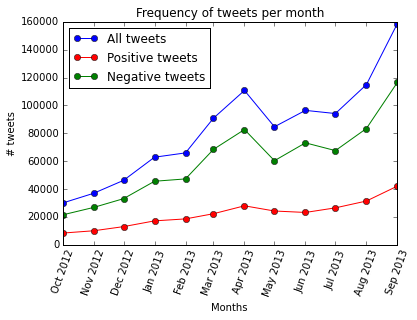

In [39]:
def tweets_by_month(tweets):
    #parsing date for all_tweets, positive and negative
    
    months = Counter(parse_date(x['posted_time']) for x in tweets)#all
    months1 = Counter(parse_date(x1['posted_time']) for x1 in tweets if x1['class']=='1')#positive
    months0 = Counter(parse_date(x0['posted_time']) for x0 in tweets if x0['class']=='0')#negative
    
    result = Counter((k, v) for k, v in months.iteritems() if k is not None)#all
    result1 = Counter((k, v) for k, v in months1.iteritems() if k is not None)#positive
    result0 = Counter((k, v) for k, v in months0.iteritems() if k is not None)#negative
    
    keys = [f for f in sorted(result.keys())if f is not None]#all
    keys1 = [d for d in sorted(result1.keys())if d is not None]#positive
    keys0 = [e for e in sorted(result0.keys())if e is not None]#negative
    
    
    values = [r[1] for r in keys]
    keys = [r[0] for r in keys]
    print 'All tweets', values, '.Total: ',sum(values)

    values1 = [r[1] for r in keys1]
    keys1 = [r[0] for r in keys1]
    print 'Positive tweets', values1, '.Total: ',sum(values1)

    values0 = [r[1] for r in keys0]
    keys0 = [r[0] for r in keys0]
    print 'Negative tweets', values0, '.Total: ',sum(values0)


    plt.figure()
    ax = plt.subplot(111)
    plt.xticks(rotation=70) 
    ax.xaxis_date()
    #plt.plot(keys, values, keys1, values1, keys0, values0)
    line, = plt.plot(keys, values,'bo-', label="Line ")#, linestyle='dotted')
    line1, = plt.plot(keys1, values1, 'ro-',label="Line 1")#, linestyle='dashed')
    line0, = plt.plot(keys0, values0, 'go-',label="Line 0")#, linestyle='dashdot')
    plt.xlabel('Months')
    plt.ylabel('# tweets')
    plt.title('Frequency of tweets per month')
    plt.legend([line, line1,line0], ["All tweets", "Positive tweets", "Negative tweets"], loc=0)

    
tweets_by_month(labeled_tweets)

** Considering just users who posted once**

In [40]:
# Retain tweets from users who have tweeted once.
user_counts = Counter(t['username'] for t in labeled_tweets)
tweets = [t for t in labeled_tweets if user_counts[t['username']] == 1]
print '%d tweets from users who tweeted once' % len(tweets)

418315 tweets from users who tweeted once


All tweets [14965, 15881, 20845, 27189, 27868, 41220, 33154, 33932, 42590, 39556, 51389, 69726] .Total:  418315
Positive tweets [4226, 5102, 6786, 8132, 8908, 10174, 9619, 9909, 8985, 10711, 13402, 17320] .Total:  113274
Negative tweets [10739, 10779, 14059, 19057, 18960, 31046, 23535, 24023, 33605, 28845, 37987, 52406] .Total:  305041


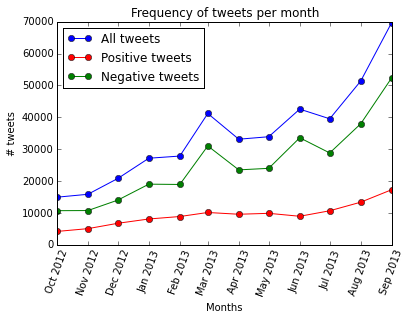

In [41]:
tweets_by_month(tweets)

** Eliminating retweets**

In [42]:
# Remove retweets
tweets_ = [t for t in tweets if t['text'][:2] != 'RT']
print '%d non RT tweets from users who tweeted once' % len(tweets)

418315 non RT tweets from users who tweeted once


All tweets [10975, 12322, 14327, 20676, 21276, 28038, 23588, 24236, 29049, 27650, 34975, 46371] .Total:  293483
Positive tweets [3569, 4223, 5274, 6859, 7125, 8784, 7570, 8127, 7688, 8678, 10357, 12208] .Total:  90462
Negative tweets [7406, 8099, 9053, 13817, 14151, 19254, 16018, 16109, 21361, 18972, 24618, 34163] .Total:  203021


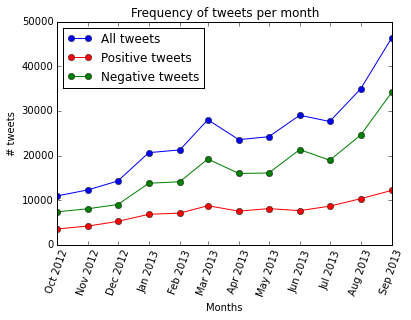

In [43]:
tweets_by_month(tweets_)

In [20]:
countss = Counter(str(v['text']).lower() for v in labeled_tweets)
#print str(tweets)
countss.most_common(15)

[('hi guys hello to all my friends if u are really my loved ones check about electronic cigarettes.its work dear',
  3368),
 ('rt @yaboylilb: *gets in booster seat*  *puts seatbelt on*  *puts in the newest kidzbop cd*  *takes drag of e-cig*  *lowers glasses*  *whisp\xe2?\xa6',
  2259),
 ('blackfriday #blackfriday  is too good for me because i used electronic cigarette which  i missed a lot',
  2024),
 ('rt @marinasdiamonds: electric cigarettes taste like school discos', 1503),
 ('blackfriday blackfriday  is too good for me because i used electronic cigarette which  i missed a lot',
  1325),
 ('rt @queen_uk: right. sorry about this. apparently camilla unplugged facebook to plug in an electric heater/cigarette lighter. awkward.',
  1195),
 ('1.6% original tobacco cartomizers.... office favorite vapes!', 1086),
 ("rt @girlcode: don't smoke cigarettes, smoke poles and by poles i mean penises. #girlcode - @tanishalong",
  1075),
 ('rt @overlymanlymann: electronic cigarettes? you mean pussy 

#Validate on new data - 200 tweets


In [23]:
#Reading 200 tweets which were manually labeled
import numpy as np
d=[]
d_200 = []

with open(DATA+'organicTweetsSample200.csv', 'rb') as sample:
    reader1 = csv.DictReader( sample )
    for s in reader1:
        d_200.append(s)
        d.append(s['sent'])
d = np.array([int(t) for t in d])#savind labels of the class in y

In [24]:
#Creating the transform 
from sklearn.feature_extraction.text import TfidfVectorizer
vec_200 = vectorizer.transform(t['text'] for t in d_200)

In [25]:
#predicting
prediction_200 = model_mod.predict(vec_200)

In [26]:
#accuracy according to labels manually put
acc =  1. * len([1 for tr, pr in zip(d, prediction_200) if tr == pr]) / len(d)
print 'Accuracy is ', acc

Accuracy is  0.785


#**Getting percentage of positive users**

In [44]:
import collections as c
d = c.defaultdict(list)
dd = c.defaultdict(list)
#getting username and the class of his/her tweet
for t in labeled_tweets:
    u = t['username']
    label = int(t['class'])
    date = parse_date(t['posted_time'])
    d[u,label,date] 
    if t['text'][:2] != 'RT': 
        dd[u,label,date]

print len(d), "with rt's"
print len(dd), "no rt's"

669504 with rt's
503295 no rt's


all [22367, 24918, 31795, 43434, 44801, 62444, 55229, 57534, 69778, 66473, 83452, 107279] 

positive [6819, 8186, 10727, 13864, 15073, 17656, 17548, 18488, 17443, 20316, 24324, 28938] 

negative [15548, 16732, 21068, 29570, 29728, 44788, 37681, 39046, 52335, 46157, 59128, 78341] 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


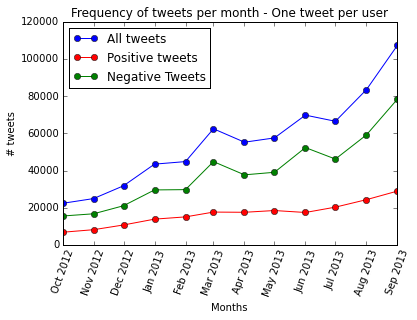

In [45]:
################################
#CONSIDERING ONE TWEET PER USER#
################################

#couting number of tweets by month
all_mon = Counter(x[2] for x in d)
monthpos11 = Counter(x[2] for x in d if x[1]==1)
monthpos00 = Counter(x[2] for x in d if x[1]==0)

#ordering by month
all_key = [f for f in sorted(all_mon.items())if f is not None]
keyspos11 = [f for f in sorted(monthpos11.items())if f is not None]
keyspos00 = [f for f in sorted(monthpos00.items())if f is not None]

all_values = [r[1] for r in all_key]
all_keys = [r[0] for r in all_key]
print 'all', all_values,'\n'


valuespos = [r[1] for r in keyspos11]
keyspos1 = [r[0] for r in keyspos11]
print 'positive',valuespos, '\n'

valuespos00 = [r[1] for r in keyspos00]
keyspos10 = [r[0] for r in keyspos00]
print 'negative',valuespos00, '\n'

%pylab inline
plt.figure()
ax = plt.subplot(111)
plt.xticks(rotation=70) 
ax.xaxis_date()
linepos, = plt.plot(keyspos1, valuespos,'ro-')
lineg, = plt.plot(keyspos10, valuespos00,'go-')
all_line, = plt.plot(all_keys, all_values,'bo-')
plt.xlabel('Months')
plt.ylabel('# tweets')
plt.title('Frequency of tweets per month - One tweet per user')
plt.legend([all_line,linepos, lineg], ["All tweets","Positive tweets", "Negative Tweets"], loc=0)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


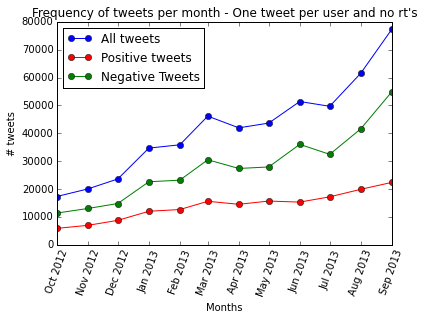

In [46]:
################################
#CONSIDERING ONE TWEET PER USER# ********NO RE-TWEETS*******
################################

#couting number of tweets by month
all_mon = Counter(x[2] for x in dd)
monthpos11 = Counter(x[2] for x in dd if x[1]==1)
monthpos00 = Counter(x[2] for x in dd if x[1]==0)

#ordering by month
all_key = [f for f in sorted(all_mon.items())if f is not None]
keyspos11 = [f for f in sorted(monthpos11.items())if f is not None]
keyspos00 = [f for f in sorted(monthpos00.items())if f is not None]

all_values = [r[1] for r in all_key]
all_keys = [r[0] for r in all_key]

valuespos = [r[1] for r in keyspos11]
keyspos1 = [r[0] for r in keyspos11]

valuespos00 = [r[1] for r in keyspos00]
keyspos10 = [r[0] for r in keyspos00]

%pylab inline
plt.figure()
ax = plt.subplot(111)
plt.xticks(rotation=70) 
ax.xaxis_date()
linepos, = plt.plot(keyspos1, valuespos,'ro-')
lineg, = plt.plot(keyspos10, valuespos00,'go-')
all_line, = plt.plot(all_keys, all_values,'bo-')
plt.xlabel('Months')
plt.ylabel('# tweets')
plt.title("Frequency of tweets per month - One tweet per user and no rt's")
plt.legend([all_line,linepos, lineg], ["All tweets","Positive tweets", "Negative Tweets"], loc=0)

199382
[6819, 8186, 10727, 13864, 15073, 17656, 17548, 18488, 17443, 20316, 24324, 28938]  total 199382 

[(datetime.date(2012, 10, 1), 6819), (datetime.date(2012, 11, 1), 8186), (datetime.date(2012, 12, 1), 10727), (datetime.date(2013, 1, 1), 13864), (datetime.date(2013, 2, 1), 15073), (datetime.date(2013, 3, 1), 17656), (datetime.date(2013, 4, 1), 17548), (datetime.date(2013, 5, 1), 18488), (datetime.date(2013, 6, 1), 17443), (datetime.date(2013, 7, 1), 20316), (datetime.date(2013, 8, 1), 24324), (datetime.date(2013, 9, 1), 28938)]
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


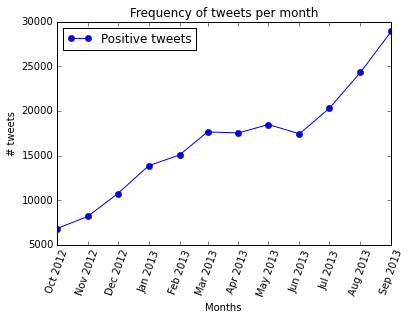

In [47]:
############################
#CONSIDERING JUST POSITIVE##
############################
#deleting keys which have label 0
for k,v in d.items():
    if k[1] != 1:
        del d[k]
print len(d)
#couting number of tweets by month
monthpos = Counter(x[2] for x in d)

#ordering by month
keyspos = [f for f in sorted(monthpos.items())if f is not None]

valuespos = [r[1] for r in keyspos]
keyspos1 = [r[0] for r in keyspos]
print valuespos,' total',  sum(valuespos),'\n'
print sorted(monthpos.items())

#plotting positive tweets by tweets, considering just one positive tweet by user   
%pylab inline
plt.figure()
ax = plt.subplot(111)
plt.xticks(rotation=70) 
ax.xaxis_date()
linepos, = plt.plot(keyspos1, valuespos,'bo-')
plt.xlabel('Months')
plt.ylabel('# tweets')
plt.title('Frequency of tweets per month')
plt.legend([linepos], ["Positive tweets"], loc=0)

In [48]:
all_users = Counter(parse_date(x['posted_time']) for x in labeled_tweets)

keys_all_users = [f for f in sorted(all_users.items())if f is not None]

values_all_users = [r[1] for r in keys_all_users]
keys_all_pos1 = [r[0] for r in keys_all_users]

#print all_users
print values_all_users,'\n'
#print keys_all_pos1

positive_users = monthpos

#ordering by month
keys_positive_users = [f for f in sorted(positive_users.items())if f is not None]

values_positive_users = [r[1] for r in keys_positive_users]
keys_pos1 = [r[0] for r in keys_positive_users]

print values_positive_users,'\n'

[30026, 36995, 46271, 62883, 65971, 90870, 110735, 84692, 96447, 94180, 114894, 158669] 

[6819, 8186, 10727, 13864, 15073, 17656, 17548, 18488, 17443, 20316, 24324, 28938] 



[18.50726014384584, 18.118235541488676, 18.819958595038422, 18.064549754387794, 18.59853906519915, 16.268912518659125, 13.67913129565102, 17.91820120178329, 15.31565545701993, 17.743851313583008, 17.471878636383227, 15.42479758217977]


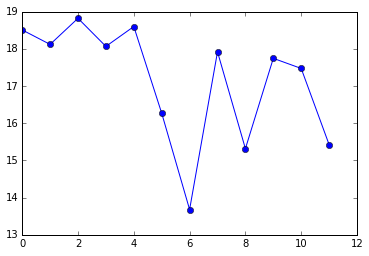

In [49]:
positive_percentil = []
for x, y in zip(values_all_users,values_positive_users):
    positive_percentil.append((y/float(y+x)*100))
print positive_percentil
plot(positive_percentil, 'bo-')

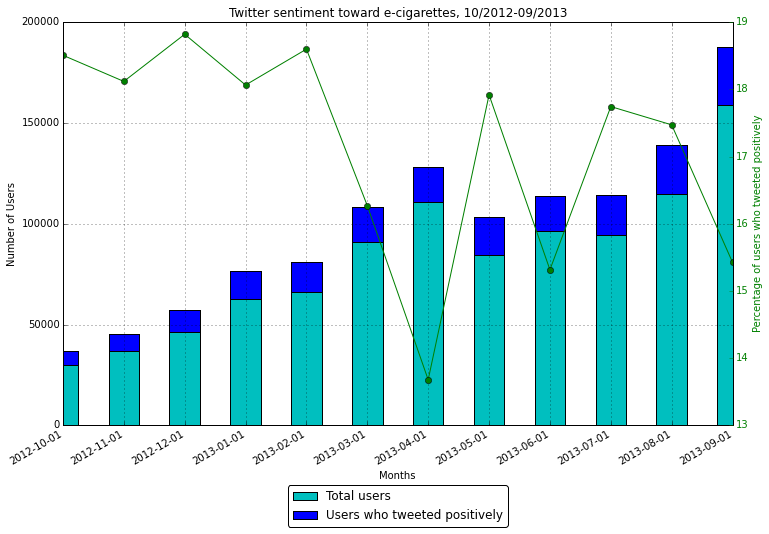

In [21]:
import pandas as pd

data1 = values_all_users
data2 = values_positive_users
B=positive_percentil
df=pd.DataFrame({'Total users':data1, 'Users who tweeted positively':data2})

df.plot(kind='bar', stacked=True,grid = True,figsize=(12,8), color='cb')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],keys_pos1)
plt.xlabel('Months')
plt.legend(loc='center',fontsize = 'large',bbox_to_anchor=(0.5,-0.2),
          ncol=1, fancybox=True)
plt.title('Twitter sentiment toward e-cigarettes, 10/2012-09/2013')

df1=pd.DataFrame({'positive_percentil':positive_percentil})
ax= df1.positive_percentil.plot(kind='line',secondary_y=True, style='go-')
ax.left_ax.set_ylabel('Number of Users')
ax.right_ax.set_ylabel('Percentage of users who tweeted positively', color='green')
ax.xaxis_date()
#plt.legend(('Positive percentile over all all tweets',),bbox_to_anchor=(0.9,-0.16),fancybox=True)
ax.tick_params(axis='y', colors='green')
gcf().autofmt_xdate()


#**Words by month**

In [57]:
positive_ones = [(t['text'],parse_date(t['posted_time'])) for t in labeled_tweets if t['class']=='1']
negative_ones = [(t['text'],parse_date(t['posted_time'])) for t in labeled_tweets if t['class']=='0']
all_ones = [(t['text'],parse_date(t['posted_time'])) for t in labeled_tweets]
print positive_ones[1], '\n', negative_ones[1]

('Ecig finally died #rip', datetime.date(2012, 10, 1)) 
('Really \xe3?? nice!: USB Rechargeable Electronic Cigarette Lighter - Green http://t.co/JS65DjB3', datetime.date(2012, 10, 1))


In [60]:
import re 

Y_pos = [p[1] for p in all_ones]

# Create feature vectors (X)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer1 = TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=10, tokenizer=tokenize1,binary=False)#lowercase, url's, mentions
X_pos = vectorizer1.fit_transform(t[0] for t in all_ones)
print 'vectorized %d tweet. found %d terms.' % (X_pos.shape[0], X_pos.shape[1])

vectorized 992633 tweet. found 30236 terms.


In [61]:
# Fit a LogisticRegression model
from sklearn.linear_model import LogisticRegression
model_positive = LogisticRegression()
model_positive.fit(X_pos, Y_pos)

'"# Compute accuracy\ndef accuracy(truth, predicted):\n    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))\n\npredicted = model_positive.predict(X_pos)\nprint \'accuracy on training data=%.3f\' % accuracy(Y_pos, predicted)\n\nfrom sklearn.cross_validation import KFold\ncv = KFold(len(Y_pos), 10)'

In [62]:
# What are the top weighted features?
vocab = np.array(vectorizer1.get_feature_names())
# Get the learned coefficients for the the class.

var=[]

for i in range(0,12):
    coef = model_positive.coef_[i]
    # Sort them in descending order.
    top_coef_ind = np.argsort(coef)[::-1]
    # Get the names of those features.
    top_coef_terms = vocab[top_coef_ind]
    # Get the weights of those features
    top_coef = coef[top_coef_ind]
    # Print the top 10.
    var.append([(term, weight) for term, weight in zip(top_coef_terms, top_coef)[:10]])
    print '\n', \
    '\n'.join('%s %.2f' % (term, weight) for term, weight in zip(top_coef_terms, top_coef)[:10])

months_ = ['Oct','Nov','Dec,','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']

for v,m in zip(var,months_):
    print m, '\n', v, '\n'


dragonfly 16.81
ltdTHIS_IS_A_URL 8.74
stoptober 7.89
discos 6.85
clik 6.71
mall 6.56
clintandrew 6.29
fuckingsmart 6.28
dispoecig 6.25
ohmyvapor 6.06

election 10.12
thanksgiving 8.61
election2012 8.17
sarapmagvape 7.71
sideburn 6.81
pattinson 6.61
shishavapes 5.96
nov 5.64
emazin 5.60
rob 5.47

mhealth 9.29
christmas 8.26
youcantbetakenseriouslyif 7.97
ganj 7.74
xmas 7.11
dec 7.00
govawards 6.33
itsabaddaywhen 6.09
camilla 5.91
legalise 5.91

igotoaschoolwhere 8.52
soar 7.92
mook 7.03
embarrassment 6.85
thingsthatbotherme 6.43
22509 5.97
36e 5.84
pst 5.84
perfects 5.81
monumental 5.79

whatevs 9.16
ecigs1 8.46
valentine 7.69
valentines 7.13
queers 6.89
superbowl 6.84
oscars 6.51
baftas 6.49
positivity 6.11
britons 6.00

onew 12.53
03 10.78
pope 9.96
vaporware 8.87
vatican 8.15
sxsw 8.10
nanopartices 7.82
conclave 7.71
faked 7.49
quitsmoking2 7.32

courtney 13.21
senators 12.17
euecigban 11.55
primarily 9.08
leachon 8.60
welcometomyschoolwhere 7.99
750 7.90
eue 7.79
mywebcamTHIS_IS_A_

**N-grams analysis **

In [7]:
import nltk
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

In [8]:
def topM_ngrams(all_words,n,m):
    
    ngrams=[]
    cnt = Counter()

    for f in all_words:
        ngrams.append(find_ngrams(nltk.word_tokenize(f.decode('"ISO-8859-1"').encode('ascii', 'ignore')),n))       

    for b in ngrams:
        for bb in b:
            cnt[bb]+=1      
    return cnt.most_common(m)


In [18]:
all_words=[]

#select month and year for analysis

for t in labeled_tweets:
    if t['posted_time'].split()[0][0:2] == '11' and t['posted_time'].split()[0][5:9]=='2012' and t['class']=='1':# and t['text'][:2] != 'RT':
        all_words.append(t['text'])

In [19]:
len(all_words)#30661-43202=12541 retweets for september

3140

In [20]:
topM_ngrams(all_words, 2, 10)

[(('RT', '@'), 679),
 (('?', '?'), 475),
 (('a', 'cigarette'), 421),
 (('need', 'a'), 374),
 (('do', "n't"), 374),
 (('cigarette', '.'), 350),
 (('this', 'election'), 303),
 (('!', '!'), 301),
 (('I', "'m"), 297),
 (("n't", 'even'), 272)]

In [21]:
topM_ngrams(all_words, 3, 10)

[(('need', 'a', 'cigarette'), 323),
 (('a', 'cigarette', '.'), 277),
 (('do', "n't", 'even'), 267),
 (("n't", 'even', 'smoke'), 263),
 (('?', '?', '?'), 258),
 (('i', 'need', 'a'), 247),
 (('with', 'this', 'election'), 242),
 (('nerves', 'bad', 'with'), 240),
 (('bad', 'with', 'this'), 240),
 (('cigarette', '.', 'Damn'), 238)]

In [22]:
topM_ngrams(all_words, 4, 10)

[(('do', "n't", 'even', 'smoke'), 263),
 (('need', 'a', 'cigarette', '.'), 259),
 (('i', 'need', 'a', 'cigarette'), 243),
 (('nerves', 'bad', 'with', 'this'), 240),
 (('a', 'cigarette', '.', 'Damn'), 237),
 (("n't", 'even', 'smoke', 'and'), 237),
 (('Damn', 'nerves', 'bad', 'with'), 237),
 (('cigarette', '.', 'Damn', 'nerves'), 237),
 (('smoke', 'and', 'i', 'need'), 236),
 (('.', 'Damn', 'nerves', 'bad'), 236)]

In [23]:
i=0
for t in labeled_tweets:
    if parse_date(t['posted_time']).month == 11 and parse_date(t['posted_time']).year == 2012 and t['class'] == '1': #and t['text'][:24] == 'BlackFriday #BlackFriday':
        print t['class'], t['username'], t['text']
        #break
        i+=1
print i     

1 moeee_sevel_ RT @juncapher97: #TweetLikeYourBestFriend yeah fuck you swag yeah systems vaper mate Nike I'm fresh I fuck botched get money @Drew_Herrage
1 MLReiley RT @Beau23: @KPelmear me and nate quit... Bought ecigs
1 EnnWhyWhy Been smoking. The shit out of this...ecig. ..  Now got a mad head ache now time for a SilkCut. #ironic
1 NorCalPurps Watching Abbot and Costello meet Frankenstein and vaping some agent orange
1 VapingDroid Taking a much needed nap. Long day at Uptown Vaper Lounge
1 KarsonCole At my school I see more electric cigarettes than I do pencils.
1 Steph_Dunne8 RT @KarsonCole: At my school I see more electric cigarettes than I do pencils.
1 JuiceAFox RT @KarsonCole: At my school I see more electric cigarettes than I do pencils.
1 21Jamichael @BougieBadAzz_14 I wanna wear the vapers
1 haykaytay RT @KarsonCole: At my school I see more electric cigarettes than I do pencils.
1 mamsxo RT @KarsonCole: At my school I see more electric cigarettes than I do pencils.
1 AngeloB

**Check percentage of tweets a words appears**

In [68]:
# Create feature vectors (B)
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=2, tokenizer=tokenize1,binary=True, stop_words='english')#lowercase, url's, mentions
B = vector.fit_transform(t['text'] for t in labeled_tweets )#if t['class']=='0')
print 'vectorized %d tweet. found %d terms.' % (B.shape[0], B.shape[1])

vectorized 992633 tweet. found 101726 terms.


In [69]:
import collections as c

BY = [(parse_date(f['posted_time'] ).month,parse_date(f['posted_time'] ).year) for f in labeled_tweets ]#if f['class']=='1']

def percentage_terms(m,y,B,BY, term):
    #month m
    #year y
    #B feature vector
    #BY vector with posted date
    
    vocabulary = np.array(vector.get_feature_names())
    dic= Counter()
    dict1 = c.defaultdict(int)
    count=0

    for i in range(len(zip(B,BY))):
        if BY[i]==(m,y):
            count+=1
            for v in set(vocabulary[B[i].indices]):     
                dic[v]+=1
    print 'Month:', m, 'has', count,'tweets. \nWord', term, 'appears in', dic[term], 'tweets.' 
    
    
    for k, v in dic.items():
        dic[k]=(v/float(count)*100)
    
    #sort= sorted(dic.items(), key=lambda x: x[1], reverse=True)
    return dic[term]

In [70]:
percentage_terms(1,2013,B,BY,'soar')

Month: 1 has 62883 tweets. 
Word soar appears in 204 tweets.


0.32441200324412006